In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load Dogecoin data
df_doge = pd.read_csv("/content/Dogecoin_cleaned.csv")
# Filter just in case there's a Crypto column
if "Crypto" in df_doge.columns:
    df_doge = df_doge[df_doge["Crypto"] == "Dogecoin"].drop(columns=["Crypto"])

# Drop missing values
df_doge.dropna(inplace=True)

# Define features and target
features = ['Open', 'High', 'Low', 'Volume', 'VWAP', 'Volatility', 'Price_Change', 'RSI', 'MACD',
            'MA_7', 'MA_14', 'EMA_7', 'EMA_14', 'Rolling_Std_7', 'Rolling_Std_14',
            'Day_of_Week', 'Month', 'Week_of_Year', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']
target = 'Close'

# Scale the features and target
scaler_features_doge = MinMaxScaler()
scaler_target_doge = MinMaxScaler()

X_scaled_doge = scaler_features_doge.fit_transform(df_doge[features])
y_scaled_doge = scaler_target_doge.fit_transform(df_doge[[target]])

# Combine
doge_scaled = pd.DataFrame(data=np.hstack((X_scaled_doge, y_scaled_doge)), columns=features + [target])


In [3]:
def create_sequences(data, seq_length):
    x_data, y_data = [], []
    for i in range(seq_length, len(data)):
        x_data.append(data.iloc[i-seq_length:i][features].values)
        y_data.append(data.iloc[i][target])
    return np.array(x_data), np.array(y_data)

# Set your sequence length
sequence_length = 30  # You can tune this later

# Create sequences
X_doge, y_doge = create_sequences(doge_scaled, sequence_length)

# Train-test split
train_size = int(len(X_doge) * 0.8)
x_train_doge, x_test_doge = X_doge[:train_size], X_doge[train_size:]
y_train_doge, y_test_doge = y_doge[:train_size], y_doge[train_size:]


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Build LSTM model
def build_doge_lstm_model():
    model = Sequential([
        Input(shape=(sequence_length, len(features))),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initialize and train
doge_model = build_doge_lstm_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

doge_model.fit(x_train_doge, y_train_doge,
               validation_data=(x_test_doge, y_test_doge),
               epochs=50,
               batch_size=32,
               callbacks=[early_stopping],
               verbose=1)

# Predict base model output
y_pred_doge = doge_model.predict(x_test_doge)


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.0109 - val_loss: 0.0599
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0016 - val_loss: 0.0325
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0011 - val_loss: 0.0243
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0010 - val_loss: 0.0279
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 9.0130e-04 - val_loss: 0.0350
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 8.3774e-04 - val_loss: 0.0279
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 8.9868e-04 - val_loss: 0.0279
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 8.2742e-04 - val_loss: 0.0308
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 7.2376e-04 - val_loss: 0.0323
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 7.3882e-04 - val_loss: 0.0398
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 6.3096e-04 - val_loss: 0.0301
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━

In [7]:
# Residual = actual - base prediction (in scaled format)
residuals_doge = y_test_doge.reshape(-1, 1) - y_pred_doge

# Residual LSTM model
def build_residual_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build & train residual model
residual_model_doge = build_residual_lstm(x_test_doge.shape[1:])
residual_model_doge.fit(x_test_doge, residuals_doge,
                        epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Predict residuals
residual_preds_doge = residual_model_doge.predict(x_test_doge)

# Final predictions = base + residual
final_preds_doge = y_pred_doge + residual_preds_doge

# Inverse transform and evaluate
final_preds_doge_inv = scaler_target_doge.inverse_transform(final_preds_doge)

mae = mean_absolute_error(y_test_doge_inv, final_preds_doge_inv)
rmse = np.sqrt(mean_squared_error(y_test_doge_inv, final_preds_doge_inv))
r2 = r2_score(y_test_doge_inv, final_preds_doge_inv)

print("\n📊 Dogecoin Hybrid LSTM + Residual Model Evaluation:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - loss: 0.0752 - val_loss: 0.0126
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0505 - val_loss: 0.0149
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0151 - val_loss: 0.0360
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0157 - val_loss: 0.0077
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0143 - val_loss: 0.0076
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0129 - val_loss: 0.0143
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0094 - val_loss: 0.0249
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0102 - val_loss: 0.0149
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0078 - val_loss: 0.0088
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0082 - val_loss: 0.0087


In [8]:
def forecast_future_days(base_model, residual_model, data_df, scaler_features, scaler_target,
                         sequence_length, features, days_ahead=14):
    predictions = []
    last_sequence = data_df[features].values[-sequence_length:]

    for _ in range(days_ahead):
        input_seq = np.expand_dims(last_sequence, axis=0)
        base_pred = base_model.predict(input_seq, verbose=0)
        residual_pred = residual_model.predict(input_seq, verbose=0)
        final_pred_scaled = base_pred + residual_pred
        final_pred = scaler_target.inverse_transform(final_pred_scaled)[0][0]
        predictions.append(final_pred)
        new_row = np.append(last_sequence[-1][:-1], final_pred_scaled[0])
        last_sequence = np.vstack([last_sequence[1:], new_row])

    return predictions

# Forecast 14 days ahead
future_preds_doge = forecast_future_days(
    base_model=doge_model,
    residual_model=residual_model_doge,
    data_df=doge_scaled,
    scaler_features=scaler_features_doge,
    scaler_target=scaler_target_doge,
    sequence_length=sequence_length,
    features=features,
    days_ahead=14
)


<ipython-input-10-a837b474c4d9>:18: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-a837b474c4d9>:18: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-a837b474c4d9>:18: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-a837b474c4d9>:18: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/

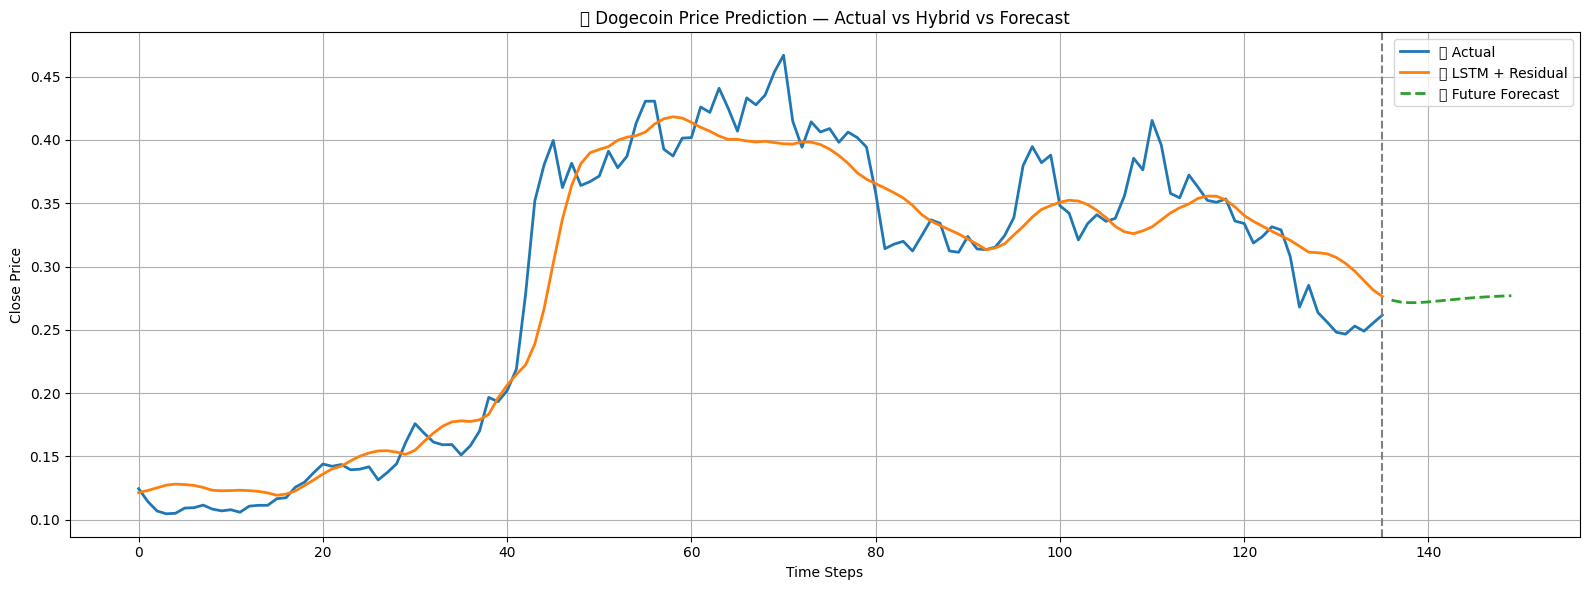

In [10]:
import matplotlib.pyplot as plt

n_test = len(y_test_doge_inv)
n_forecast = len(future_preds_doge)
x_actual = np.arange(n_test)
x_forecast = np.arange(n_test, n_test + n_forecast)

plt.figure(figsize=(16, 6))
plt.plot(x_actual, y_test_doge_inv, label='📌 Actual', linewidth=2)
plt.plot(x_actual, final_preds_doge_inv, label='🔁 LSTM + Residual', linewidth=2)
plt.plot(x_forecast, future_preds_doge, label='🔮 Future Forecast', linewidth=2, linestyle='dashed')
plt.axvline(x=n_test - 1, color='gray', linestyle='--')
plt.title("📈 Dogecoin Price Prediction — Actual vs Hybrid vs Forecast")
plt.xlabel("Time Steps")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import os
import joblib

os.makedirs("models", exist_ok=True)

# Save models
doge_model.save("models/LSTM_Dogecoin_Base.h5")
residual_model_doge.save("models/LSTM_Dogecoin_Residual.h5")

# Save scalers
joblib.dump(scaler_features_doge, "models/scaler_features_Dogecoin.pkl")
joblib.dump(scaler_target_doge, "models/scaler_target_Dogecoin.pkl")

print("✅ All Dogecoin models and scalers saved!")


✅ All Dogecoin models and scalers saved!


In [12]:
from google.colab import files
files.download("models/LSTM_Dogecoin_Base.h5")
files.download("models/LSTM_Dogecoin_Residual.h5")
files.download("models/scaler_features_Dogecoin.pkl")
files.download("models/scaler_target_Dogecoin.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>